In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from pprint import pprint
from math import sqrt

#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')


In [2]:
day_of_week_translator = {
    0: "Domingo",
    1: "Segunda",
    2: "Terca",
    3: "Quarta",
    4: "Quinta",
    5: "Sexta",
    6: "Sabado"
}

feriados = [
            ['Ano Novo', 1, 1],
            ['Carnaval', 24, 2],
            ['Carnaval', 25, 2],
            ['Carnaval', 26, 2],
            ['Dia de São José', 19, 3],
            ['Data Magna', 25, 3],
            ['Sexta-Feira Santa', 10, 4],
            ['Aniversário de Fortaleza', 13, 4],
            ['Tiradentes', 21, 4],
            ['Dia do Trabalho', 1, 5],
            ['Corpus Christi', 28, 5],
            ['N. Senhora da Assunção', 27, 5],
            ['Independência do Brasil', 7, 9],
            ['N. Senhora de Aparecida', 12, 10],
            ['Dia de Finados', 2, 11],
            ['Proclamação da Republica', 15, 11],
            ['Natal', 25, 12],
]

vesperas = [
            ['Ano Novo', 31, 12],
            ['Carnaval', 23, 2],
            ['Dia de São José', 18, 3],
            ['Data Magna', 24, 3],
            ['Sexta-Feira Santa', 9, 4],
            ['Aniversário de Fortaleza', 12, 4],
            ['Tiradentes', 20, 4],
            ['Dia do Trabalho', 30, 4],
            ['N. Senhora da Assunção', 26, 5],
            ['Independência do Brasil', 6, 9],
            ['N. Senhora de Aparecida', 11, 10],
            ['Dia de Finados', 1, 11],
            ['Proclamação da Republica', 14, 11],
            ['Natal', 24, 12],
]

In [3]:
# Reading Data file (geolocalized)
data = pd.read_csv('./df_input.csv', sep=';', delimiter=';')

transformar_features = True
busline_filter = 41
data_model = data.copy()

one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]
data_model['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]

encoded_model_data = data_model.loc[data['linha'] == busline_filter].copy()
df_dados_model = encoded_model_data.copy()
display(encoded_model_data)

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
2418,41,2020-03-01 04:00:00,25,6,8.878852e-01,0.460065,4,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2419,41,2020-03-01 05:00:00,168,6,9.790841e-01,0.203456,5,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2420,41,2020-03-01 06:00:00,310,6,9.976688e-01,-0.068242,6,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2421,41,2020-03-01 07:00:00,339,6,9.422609e-01,-0.334880,7,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2422,41,2020-03-01 08:00:00,286,6,8.169699e-01,-0.576680,8,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418148,41,2020-12-31 20:00:00,138,3,-7.308360e-01,0.682553,20,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418149,41,2020-12-31 21:00:00,83,3,-5.195840e-01,0.854419,21,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418150,41,2020-12-31 22:00:00,54,3,-2.697968e-01,0.962917,22,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418151,41,2020-12-31 23:00:00,30,3,-2.449294e-16,1.000000,23,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [4]:
feature_names = [
    'd_semana', 'hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado']

target = encoded_model_data['validations_per_hour']

if(transformar_features): 
    scaler = MinMaxScaler(feature_range=(0, 1))

    df_dados_model[feature_names] = scaler.fit_transform(df_dados_model[feature_names])

    df_dados_model
df_dados_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
2418,41,2020-03-01 04:00:00,25,1.000000,0.944980,0.728769,4,0.0,0.164384,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2419,41,2020-03-01 05:00:00,168,1.000000,0.990686,0.599865,5,0.0,0.164384,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2420,41,2020-03-01 06:00:00,310,1.000000,1.000000,0.463380,6,0.0,0.164384,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2421,41,2020-03-01 07:00:00,339,1.000000,0.972231,0.329437,7,0.0,0.164384,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2422,41,2020-03-01 08:00:00,286,1.000000,0.909439,0.207971,8,0.0,0.164384,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418148,41,2020-12-31 20:00:00,138,0.500000,0.133728,0.840534,20,1.0,1.000000,1.000000,0.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1418149,41,2020-12-31 21:00:00,83,0.500000,0.239601,0.926869,21,1.0,1.000000,1.000000,0.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1418150,41,2020-12-31 22:00:00,54,0.500000,0.364786,0.981372,22,1.0,1.000000,1.000000,0.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1418151,41,2020-12-31 23:00:00,30,0.500000,0.500000,1.000000,23,1.0,1.000000,1.000000,0.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [5]:
X = df_dados_model.filter(['d_semana', 'hour_sin', 'hour_cos', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado'], axis=1)
y = df_dados_model.validations_per_hour
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [10]:
def getModel():
    model = tf.keras.Sequential()
    
    # MLP    
    model.add(tf.keras.layers.Dense(300, activation="relu"))
    model.add(tf.keras.layers.Dense(100, activation="relu"))
    model.add(tf.keras.layers.Dense(30, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="relu"))
    
    # Vanilla LSTM
    # model.add(tf.keras.layers.LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        
    # Stacked LSTM
    # model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]) ))
    # model.add(tf.keras.layers.LSTM(75, activation='relu', return_sequences=True))
    # model.add(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True))
    # model.add(tf.keras.layers.LSTM(10, activation='relu'))
    
    # Bidirectional LSTM
#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(tf.keras.layers.Dense(units=1,activation='softplus'))
    # model.add(tf.keras.layers.Dense(units=1))

    return model

In [21]:
model = getModel()

optimizer = tf.keras.optimizers.Adam(0.002)

model.compile(
  loss='mse',
  optimizer=optimizer
)
# model.compile(
#   loss='mean_squared_error',
#   optimizer=tf.keras.optimizers.SGD(0.05)
# )

#model.summary()

In [12]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4, mode='min')]

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True))

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=48,
    validation_split=0.2,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

83/83 [==============================] - 0s 3ms/step - loss: 107718.9609 - val_loss: 61927.3594
Epoch 2/500
83/83 [==============================] - 0s 1ms/step - loss: 50941.9961 - val_loss: 45152.4492
Epoch 3/500
83/83 [==============================] - 0s 1ms/step - loss: 41947.7344 - val_loss: 43127.7969
Epoch 4/500
83/83 [==============================] - 0s 1ms/step 

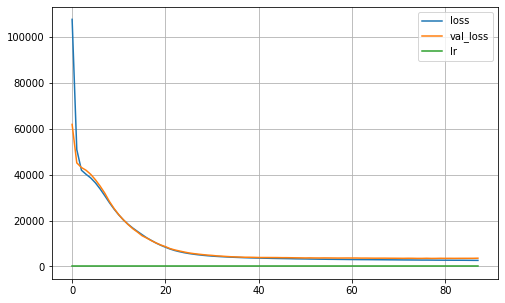

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [19]:
sample = X_test.sample(n=1)
predict_res = model.predict(sample)

print("Random -> resultado do predict de test: ", predict_res)

Random -> resultado do predict de test:  [[403.2064]]


In [20]:
display(df_dados_model.loc[sample.index[0]:sample.index[0]])

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
645855,41,2020-07-17 13:00:00,349,0.666667,0.300334,0.036909,13,0.533333,0.542466,0.545455,0.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
## Contrucao de exemplo para previsoes
# 'd_semana', 'hour_sin', 'hour_cos', 
    # 'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    # 'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    # 'feriado', 'vespera_feriado'
# 24hrs para cada dia para uma determinada linha unica no caso do treinamento
predicts = []
test_cases = [
    [0, 24, 24, 2, 122, 5, 2,1,0,0,0,0,0,0,0,0] #domingo (2 de maio de 2021)
    [1, 24, 24, 3, 123, 5, 2,0,1,0,0,0,0,0,0,0] #segunda
    [2, 24, 24, 4, 124, 5, 2,0,0,1,0,0,0,0,0,0] #terca
    [3, 24, 24, 5, 125, 5, 2,0,0,0,1,0,0,0,0,0] #quarta
    [4, 24, 24, 6, 126, 5, 2,0,0,0,0,1,0,0,0,0] #quinta
    [5, 24, 24, 7, 127, 5, 2,0,0,0,0,0,1,0,0,0] #sexta
    [6, 24, 24, 8, 128, 5, 2,0,0,0,0,0,0,1,0,0] #sabado
]


for case in test_cases:
    for h in range(0,23):
        case[1] = np.sin(2 * np.pi * h /23.0) #h_sin
        case[2] = np.cos(2 * np.pi * h /23.0) #h_cos
        pred = model.predict(case)
        predicts.append(pred)

#plot predictions

plt.figure(figsize=(12, 5))
plt.plot(predicts)


In [14]:
# PREVENDO test_size DIAS

# preds = []

# base_teste = np.copy(X_test)

# for i in range(len(base_teste)):
    
#     y_pred = model.predict(np.array([base_teste[i]]))[0][0]

#     preds.append(y_pred)

#     for k in range(len(preds)):
        
#         if k < time_steps:
#             if(i<len(base_teste)-1):
#                 base_teste[i+1][0][(time_steps-1)-k] = preds[(len(preds)-1)-k]

# preds

NameError: name 'time_steps' is not defined

In [ ]:
base_teste[0].shape

In [ ]:
# APLICANDO O INVERSE SCALING NOS DADOS
if(transformar_features):
    df_dados_model[feature_names] = scaler.inverse_transform(df_dados_model[feature_names])
# dados_predito

In [ ]:
df_real_predito = pd.DataFrame({'real':dados_real,'predito':dados_predito})

df_real_predito

In [ ]:
plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')
# plt.xlim(0,200)
# plt.ylim(40,200)
plt.show()

In [ ]:
plt.scatter(df_real_predito['real'],df_real_predito['predito'])

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))
print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))